# 階層ベイズメールーGLMMのベイズモデル化ー

階層事前分布を使って、一般化線形混合モデルを階層ベイズモデルとして扱う方法を説明します。

統計モデルを複雑にすると、パラメータ推定も難しくなります。階層ベイズモデルとMCMCサンプリングによるパラメーター推定という組み合わせが威力を発揮するのはこのような状況です。

## 10.1個体差と生存種子数（個体差あり）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pymc
import statsmodels.api as sm
from scipy import stats
%matplotlib inline

In [60]:
data = pd.read_csv('data7a.csv')

In [61]:
data.y.describe()

count    100.000000
mean       4.030000
std        3.150934
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max        8.000000
Name: y, dtype: float64

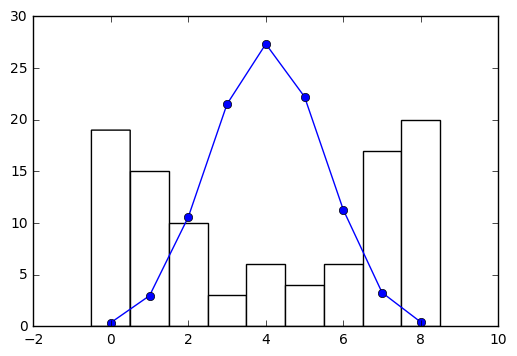

In [4]:
plt.hist(data.y,bins=np.linspace(-0.5,8.5,10),color='white')
plt.plot(np.linspace(0,8,9),scipy.stats.binom.pmf(np.linspace(0,8,9),8,0.504)*100,'o-')
plt.show()

二項分布によるモデルでは、観測データを説明できていない。

In [5]:
data_c = sm.add_constant(data.y)
data['N-y'] = 8 - data['y']
model = sm.GLM(data[['y','N-y']],data_c['const'],family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y', 'N-y']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -380.97
Date:                Tue, 07 Feb 2017   Deviance:                       631.49
Time:                        18:05:22   Pearson chi2:                     491.
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0150      0.071      0.212      0.832        -0.124     0.154
==============================================================================
"""

In [6]:
print('survival probability:%.3f') %(1 / (1+np.exp(-result.params[0])))

survival probability:0.504


In [7]:
stats.binom.var(8,0.504)

1.9998720000000001

例題では、説明変数がなく、最尤推定値は0.504となります。このモデルの分散は約2.0となると期待されますが観測データは9.93で5倍近くも大きな値となり、過分散となっている。

## 10.2GLMMの階層ベイズモデル化
個体ごとに由来する原因不明な差異などを組み込んだGLMがGLMMです。ここではGLMMのベイズモデル化に取り組みます。

ここで登場するGLMMではリンク関数と線形予測子を$logit(q_{i})=\beta + r_{i}$とする。切片$\beta$は全個体に共通するパラメータであり、個体差を表す$r_{i}$は平均ゼロでsの正規分布に従うと仮定します。

今回推定したい事後分布は以下のようになるので、あとは事前分布を指定すればモデルの設計は完了します。


事後分布$\propto p({\bf Y}|\beta,{r_{i}})\times$事前分布

$\beta$は特に制約はないので、無情報事前分布とする。

個体差$r_{i}$のパラメータの事前分布はどうすれば良いか。以前は、個体ごとに異なるパラメータ$r_{i}$が、いずれも平均ゼロで標準偏差sの正規分布従うと仮定していました。ここでも同じように$r_{i}$の事前分布が

$$p(r_{i}|s)=\frac{1}{\sqrt{2 \pi s^{2}}}exp(\frac{-r^{2}_{i}}{2s^{2}})$$

であるとする。最後に残された問題は、この個体差のばらつきsというパラメータの扱いです。ベイズ統計モデルではsの事後分布を推定します。

事後分布を推定するためには事前分布指定しなければなりません。sは正のあたいであれば何だったいいので無情報事前分布としてよい。ここでは一様分布を使う。

sはハイパーパラメータと呼ばれることもある。

## 10.3階層ベイズモデルの推定・予測
ベイズモデルでは、「推定したいパラメータ」はことごとく事前分布とデータに基づいた事後分布が推定されます。つまり、この例題の階層ベイズモデルの事後分布とは、
$$p(\beta,s,r_{i}|{\bf Y}) \propto p({\bf Y}|\beta,r_{i})p(\beta)p(s)\Pi_{i}p(r_{i}|s)$$

In [8]:
Y = data.y
N = len(Y)
s = pymc.Uniform(name='s',lower=0,upper = 1.0e+4,value=0.01) #階層事前分布のパラメータの事前分布
b = pymc.Normal(name='b', mu=0.0, tau=1.0e+2) #ベータの事前分布

r = [pymc.Normal(name='r_{0}'.format(i),mu=0,tau=s**(-2)) for i in range(N)] #階層事前分布
p = pymc.Lambda('p',lambda r = r,b=b:pymc.invlogit(b+r)) #q=1/(1+exp(-(beta+r)))

obs = pymc.Binomial(name='obs',n=8,p=p,value=Y,observed=True)
model = pymc.Model([b,s,obs])

In [47]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 135.5 sec

In [10]:
from PIL import Image

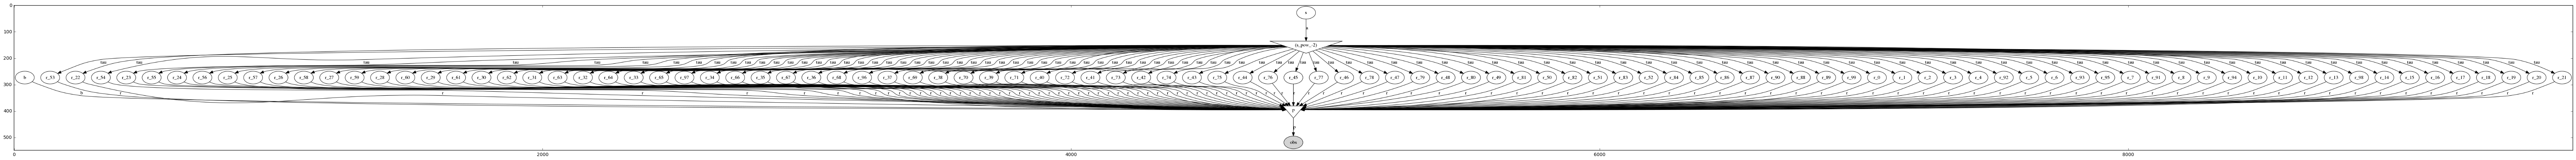

In [11]:
plt.figure(figsize=(100,10))
pymc.graph.graph(model, format='png', path='',name='model',prog='dot')
img = np.array(Image.open('model.png'))
plt.imshow(img)

### 10.3.2 階層ベイズモデルの事後分布推定と予測
生存種子数yの確率分布は、二項分布$p(y|\beta,r)$と正規分布$p(r|s)$の無限混合分布であり、以下のような式で表せるとする。
$$p(y|\beta,s)=\int_{-\infty}^{\infty}p(y|\beta,r)p(r|s)dr$$

ここで登場するrについての積分とは、事後分布p(r|s)に従うような事物を無限個集めてきて、その平均を評価しているという意味だと考えてください。

Plotting b


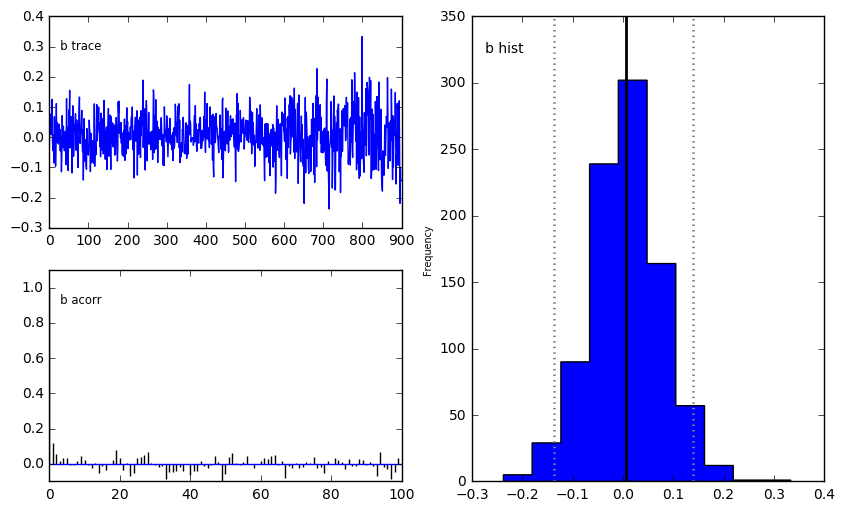

In [13]:
pymc.Matplot.plot(mcmc.trace('b'),common_scale=False)

Plotting s


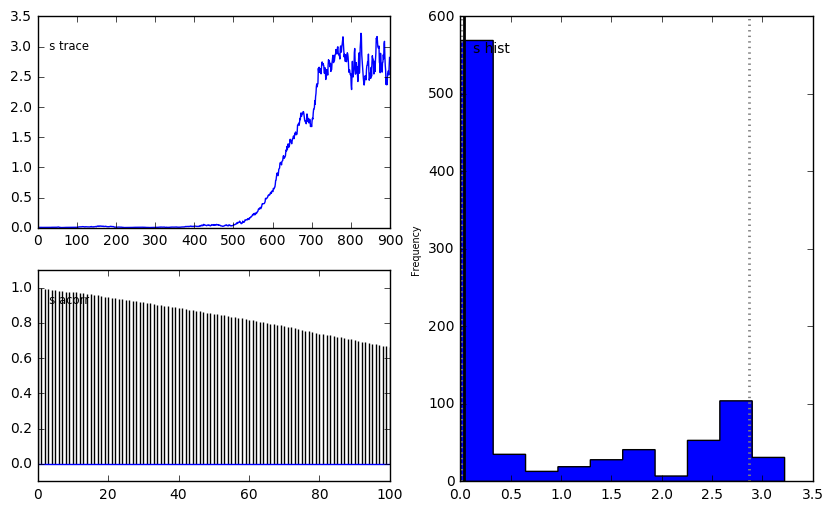

In [14]:
pymc.Matplot.plot(mcmc.trace('s'),common_scale=False)

Plotting r_0


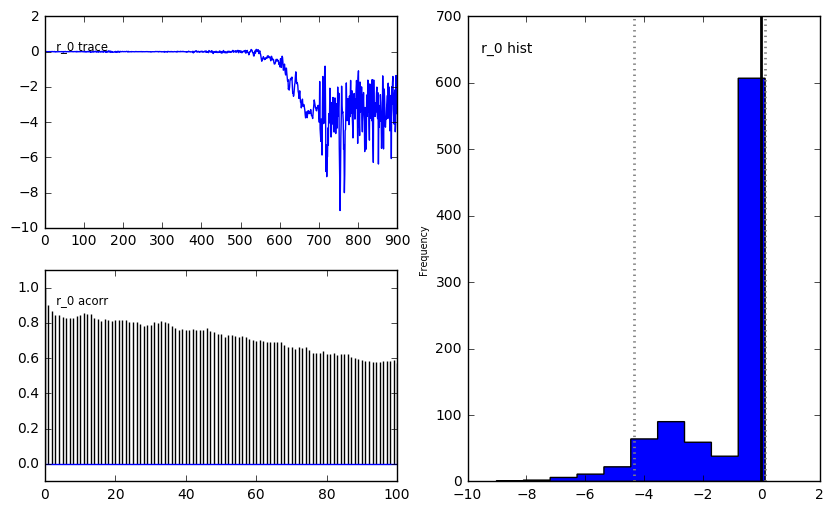

In [15]:
pymc.Matplot.plot(mcmc.trace('r_0'),common_scale=False)

Plotting r_1


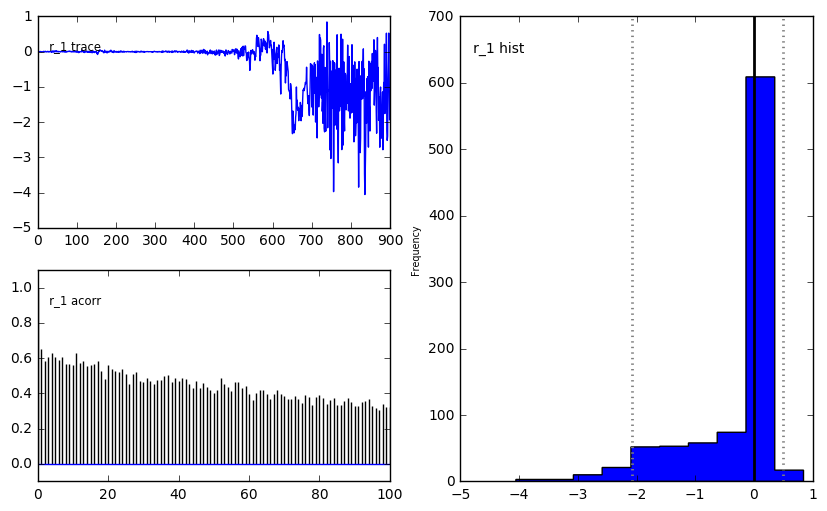

In [21]:
pymc.Matplot.plot(mcmc.trace('r_1'),common_scale=False)

Plotting r_2


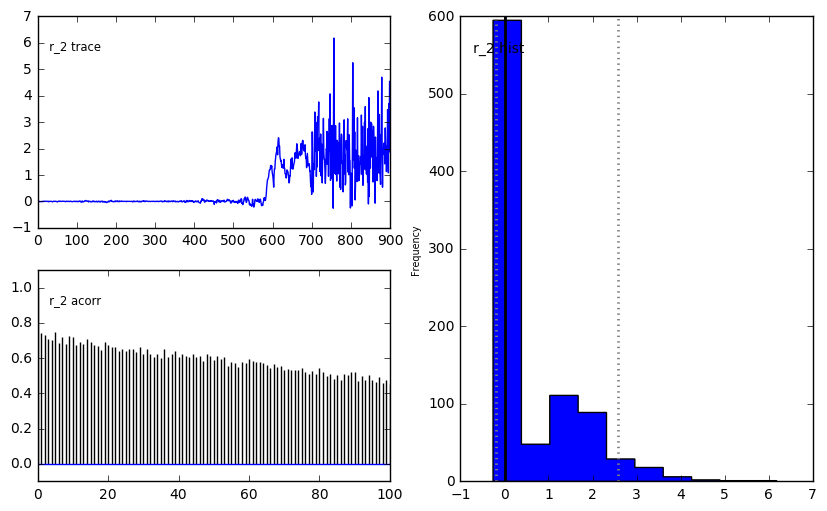

In [22]:
pymc.Matplot.plot(mcmc.trace('r_2'),common_scale=False)

600あたりくらいからうまくサンプリングできていいそう。

In [16]:
left = 600

L = []
b_= np.mean(mcmc.trace('b')[left:])

for i in range(N):
    ri = np.mean(mcmc.trace('r_{0}'.format(i))[left:])
    L.append(pymc.binomial_expval(n=8,p=pymc.invlogit(b_+ri)))

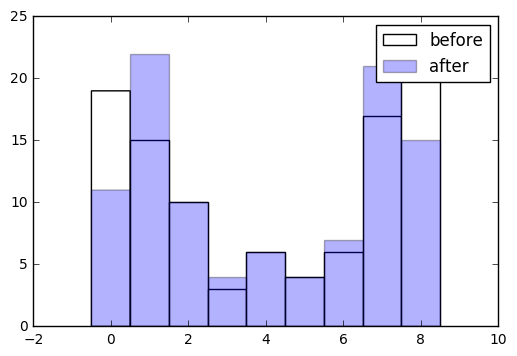

In [35]:
n_b, bins_b, pathces_b = plt.hist(data.y,bins=np.linspace(-0.5,8.5,10),color='white',label='before')
n_a, bins_a, pathces_a = plt.hist(L,bins=np.linspace(-0.5,8.5,10),color='blue',label='after',alpha=0.3)
plt.legend()
plt.show()


推定された事後分布を組み合わせて、生存種子数ごとの個体数の分布を予測

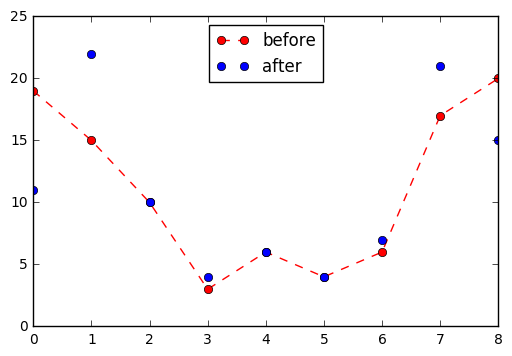

In [40]:
plt.plot(np.linspace(0,8,9),n_b,'ro--',label='before')
plt.plot(np.linspace(0,8,9),n_a,'bo',label='after')
plt.legend(loc='upper center')

In [41]:
left = 600

sample = []
b_= np.mean(mcmc.trace('b')[left:])

for i in range(N):
    ri = np.mean(mcmc.trace('r_{0}'.format(i))[left:])
    L.append(pymc.binomial_expval(n=8,p=pymc.invlogit(b_+ri)))

In [49]:
mcmc.trace('b')[600:].shape

(300,)

In [50]:
N

100

In [53]:
left = 600
Big = []
for i in range(mcmc.trace('b')[left:].shape[0]):
    data = []
    for j in range(N):
        r = mcmc.trace('r_{0}'.format(j))[left+i]
        q = pymc.binomial_expval(n=8,p=pymc.invlogit(mcmc.trace('b')[left+i]+r))
        data.append(q)
    Big.append(data)

In [57]:
np.array(Big).shape

(300, 100)

In [63]:
L

[0.32796117418634957,
 1.9904539948863131,
 6.7980421395160455,
 7.6227698366134895,
 1.2215323288565354,
 6.8723697206410641,
 7.6922872697728524,
 7.3715945544925399,
 1.2180308944259022,
 1.3458620069499074,
 4.1469759795235666,
 0.33564483253595251,
 1.1270339691609641,
 3.7443828064656084,
 6.872700450802359,
 7.4980174093428555,
 6.8741036617127307,
 0.21266728111196051,
 2.2761938161081239,
 2.5898778180491191,
 1.3674025919864574,
 1.6455327051919637,
 4.8062934224455773,
 6.8149172952737338,
 7.7063572916429877,
 3.1417280689113194,
 7.5813282780784137,
 4.3326051875677445,
 5.9266607377704776,
 0.50189097163882779,
 7.5654910566087867,
 6.7761328419271347,
 7.5591526089892094,
 0.44501767208909632,
 2.1445696755203003,
 6.2225874001475958,
 6.5600519434767266,
 7.523076719497058,
 1.9381952527199595,
 1.2442464208311561,
 1.1128409607686627,
 0.50400541354476924,
 0.53606854037913765,
 6.7952183378637097,
 7.5901832676606888,
 5.1947549149656247,
 6.7383346609258066,
 2.28469